# Hyperparemeter optimization of networks to predict wpm


## Set up


In [1]:
# Building on the basic pytorch model in nn-predict.ipynb, develop ML pipeline with 
# hyperparameter optimization
# See https://appsilon.com/pytorch-neural-network-tutorial/ for a simple example

# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR


from src import process
from src import models

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()
# display(df.head())
# display(df.tail())

## Train network


In [3]:
# Prepare data

# Include trial types above a certain threshold of occurances
min_trial_count = 100
combined_id_value_counts = df["combined_id"].value_counts()
combined_id_value_counts = combined_id_value_counts[
    combined_id_value_counts >= min_trial_count
]

valid_trial_ids = combined_id_value_counts.index.tolist()
feature_cols = ["combined_id", "acc", "trial_num", "trial_type_num"]
target_col = ["wpm"]

X_df = df.loc[
    df["combined_id"].isin(valid_trial_ids),
    feature_cols,
]
Y_df = df[df["combined_id"].isin(valid_trial_ids)][target_col]

# Convert X_df['combined_id'] to a 1-hot encoding
X_df = pd.get_dummies(X_df, columns=["combined_id"]).astype(int)

display(X_df.head())
display(Y_df.head())

,acc,trial_num,trial_type_num,combined_id_2,combined_id_17,combined_id_25,combined_id_29,combined_id_34
5,91,6,1,1,0,0,0,0
6,95,7,2,1,0,0,0,0
7,93,8,3,1,0,0,0,0
8,93,9,4,1,0,0,0,0
9,90,10,5,1,0,0,0,0


,wpm
5,52.39
6,64.39
7,57.79
8,58.39
9,53.79


## Iterate over hyperparameter grid


In [4]:
# Parameters
params = type("params", (object,), {})()
params.log_interval = np.inf  # How often to log results in epochs, not implemented yet
params.lr = 1e-3  # Learning rate
params.weight_decay = 1e-5
params.n_epochs = 1000
params.gamma = 0.999  # Learning rate decay
params.device = None  # Set later
n_hidden_units = 10
batch_size = 250
train_size = 0.8
use_cuda = True
dry_run = None  # not implemented yet
save_model = None  # not implemented yet
test_batch_size = None  # not implemented yet
seed = 42

params.device = torch.device(
    "cuda" if torch.cuda.is_available() and use_cuda else "cpu"
)
print(f"Using device: {params.device}")

Using device: cuda


In [5]:
torch.manual_seed(seed)

# Set up data
X = torch.tensor(X_df.values, dtype=torch.float)
y = torch.tensor(Y_df.values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

n_layers = np.array([1, 5])
n_units = np.array([100, 1000])


final_train_loss, final_test_loss = [], []
input_n = X.shape[1]
output_n = y.shape[1]

for i in range(len(n_units)):
    for j in range(len(n_layers)):
        modelStartTime = time.time()

        # model = models.MLPcondensed(input_n, n_hidden_units, output_n).to(device)
        model = models.MLPCondensedVariable(
            input_n, n_units[i], output_n, n_layers[j]
        ).to(params.device)

        # Set up for training
        optimizer = torch.optim.Adam(
            params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
        )
        scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
        loss_function = nn.MSELoss()

        # Train model
        train_loss, test_loss = models.train_and_evaluate(
            model,
            train_loader,
            test_loader,
            scheduler,
            optimizer,
            loss_function,
            params,
        )

        # Append results and print
        final_train_loss.append(
            {"n_layers": n_layers[j], "n_units": n_units[i], "RMSE": train_loss[-1]}
        )
        final_test_loss.append(
            {"n_layers": n_layers[j], "n_units": n_units[i], "RMSE": test_loss[-1]}
        )
        print(
            f"n_units: {n_units[i]}, n_layers: {n_layers[j]}, test RMSE: {test_loss[-1]:.2f}, time: {time.time() - modelStartTime:.2f}"
        )

train_loss_df = (
    pd.DataFrame(final_train_loss)
    .sort_values(by=["n_layers", "n_units"])
    .reset_index(drop=True)
)
test_loss_df = (
    pd.DataFrame(final_test_loss)
    .sort_values(by=["n_layers", "n_units"])
    .reset_index(drop=True)
)
display(test_loss_df)

n_units: 100, n_layers: 1, test RMSE: 22.91, time: 14.62
n_units: 100, n_layers: 5, test RMSE: 14.36, time: 16.50
n_units: 1000, n_layers: 1, test RMSE: 19.16, time: 14.68
n_units: 1000, n_layers: 5, test RMSE: 14.24, time: 21.64


,n_layers,n_units,RMSE
0,1,100,22.912954
1,1,1000,19.161755
2,5,100,14.357103
3,5,1000,14.244017


Epoch [ 100/1000], Train loss: 270.3654, Test loss: 274.5764, Run Time: 02.08
Epoch [ 200/1000], Train loss: 225.2882, Test loss: 229.5260, Run Time: 04.33
Epoch [ 300/1000], Train loss: 189.0275, Test loss: 197.6012, Run Time: 06.46
Epoch [ 400/1000], Train loss: 77.7277, Test loss: 97.3184, Run Time: 08.59
Epoch [ 500/1000], Train loss: 47.3344, Test loss: 64.7773, Run Time: 10.80
Epoch [ 600/1000], Train loss: 39.0757, Test loss: 54.1552, Run Time: 13.00
Epoch [ 700/1000], Train loss: 36.3661, Test loss: 44.8978, Run Time: 15.13
Epoch [ 800/1000], Train loss: 32.3208, Test loss: 39.2423, Run Time: 17.33
Epoch [ 900/1000], Train loss: 25.1450, Test loss: 34.8354, Run Time: 19.71
Epoch [1000/1000], Train loss: 23.9406, Test loss: 32.9428, Run Time: 22.19


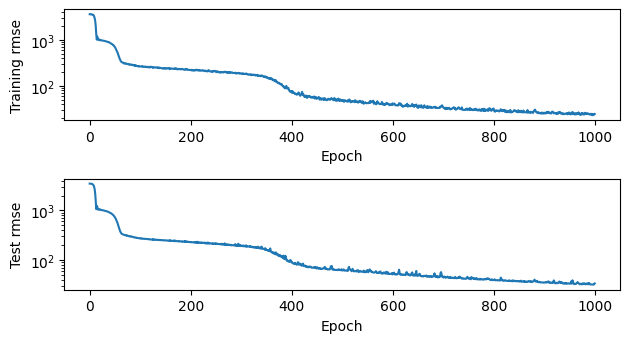

In [6]:
# Train a single model
torch.manual_seed(0)

params.log_interval = 100  # How often to log results in epochs
params.n_epochs = 1000  # 1000
params.weight_decay = 1e-4  # 1e-5 # 0 is default
params.lr = 1e-4
n_units = 100
n_layers = 10

# Set up for training
model = models.MLPCondensedVariable(input_n, n_units, output_n, n_layers).to(
    params.device
)
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)


# Plot the training and test RMSE
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[0, 0])
ax.plot(train_loss)
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training rmse")
ax = fig.add_subplot(gs[1, 0])
ax.plot(test_loss)
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Test rmse")
fig.align_labels()
plt.show()